## Installing New Libraries

## Importing Libraries

In [106]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pymongo import MongoClient
import sqlalchemy as db

import sys
from sklearn.model_selection import train_test_split
from sklift.models import TwoModels
from sklift.models import SoloModel
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklift.metrics import uplift_at_k, uplift_auc_score, qini_auc_score

In [107]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Exploratory Data Analysis (EDA)

In [3]:
# The data contains 10 million rows, we'll be working on 1 million rows of data.

df_message = pd.read_csv('messages-demo.csv')
df_lim = df_message.iloc[:1000000, :]

df_lim.to_csv('messages_data.csv', index=False)

In [108]:
# Reading the messages data

df = pd.read_csv('messages_data.csv', low_memory=False)
df.head(3)

,id,message_id,campaign_id,message_type,client_id,channel,category,platform,email_provider,stream,date,sent_at,is_opened,opened_first_time_at,opened_last_time_at,is_clicked,clicked_first_time_at,clicked_last_time_at,is_unsubscribed,unsubscribed_at,is_hard_bounced,hard_bounced_at,is_soft_bounced,soft_bounced_at,is_complained,complained_at,is_blocked,blocked_at,is_purchased,purchased_at,created_at,updated_at
0,3527358,3f6aaad3-bab7-4886-b083-fe8c1f210066,31,transactional,1515915625489833514,email,NaN,NaN,mail.ru,desktop,2021-04-30,2021-04-30 11:27:43,t,2021-05-04 05:47:05,2021-05-04 05:47:05,t,2021-05-04 05:47:46,2021-05-04 05:47:46,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,t,2021-05-06 16:40:38,2023-04-27 08:55:05.883908,2023-04-27 08:57:33.080129
1,3527619,0e670ecc-4549-44f6-86ed-469682d34837,32,transactional,1515915625489220445,email,NaN,NaN,yandex.ru,desktop,2021-04-30,2021-04-30 08:00:35,t,2021-05-04 15:38:20,2021-05-04 15:38:20,f,NaN,NaN,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,2023-04-27 08:55:06.265821,2023-04-27 08:56:18.60223
2,3527980,276b25cf-1bda-4faf-b3a4-98e4161f9357,32,transactional,1515915625489854185,email,NaN,NaN,mail.ru,desktop,2021-04-30,2021-04-30 05:56:37,t,2021-05-04 15:16:32,2021-05-04 15:16:32,f,NaN,NaN,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,2023-04-27 08:55:06.777039,2023-04-27 08:56:19.112546


In [109]:
df.shape

(1000000, 32)

In [110]:
# Checking missing values

df.isna().sum()

id                             0
message_id                     0
campaign_id                    0
message_type                   0
client_id                      0
channel                        0
category                 1000000
platform                  990768
email_provider            925500
stream                         0
date                           0
sent_at                        0
is_opened                      0
opened_first_time_at      872433
opened_last_time_at       872433
is_clicked                     0
clicked_first_time_at     995882
clicked_last_time_at      995882
is_unsubscribed                0
unsubscribed_at           864735
is_hard_bounced                0
hard_bounced_at           999444
is_soft_bounced                0
soft_bounced_at           999969
is_complained                  0
complained_at             999911
is_blocked                     0
blocked_at               1000000
is_purchased                   0
purchased_at              999765
created_at

## Pre-processing & Data Visualization of Messages data

Message row is an individual message sent to a single recipient. It contains type, channel, recipient and some metrics, described below.

In [111]:
df.head(2)

,id,message_id,campaign_id,message_type,client_id,channel,category,platform,email_provider,stream,date,sent_at,is_opened,opened_first_time_at,opened_last_time_at,is_clicked,clicked_first_time_at,clicked_last_time_at,is_unsubscribed,unsubscribed_at,is_hard_bounced,hard_bounced_at,is_soft_bounced,soft_bounced_at,is_complained,complained_at,is_blocked,blocked_at,is_purchased,purchased_at,created_at,updated_at
0,3527358,3f6aaad3-bab7-4886-b083-fe8c1f210066,31,transactional,1515915625489833514,email,NaN,NaN,mail.ru,desktop,2021-04-30,2021-04-30 11:27:43,t,2021-05-04 05:47:05,2021-05-04 05:47:05,t,2021-05-04 05:47:46,2021-05-04 05:47:46,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,t,2021-05-06 16:40:38,2023-04-27 08:55:05.883908,2023-04-27 08:57:33.080129
1,3527619,0e670ecc-4549-44f6-86ed-469682d34837,32,transactional,1515915625489220445,email,NaN,NaN,yandex.ru,desktop,2021-04-30,2021-04-30 08:00:35,t,2021-05-04 15:38:20,2021-05-04 15:38:20,f,NaN,NaN,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,2023-04-27 08:55:06.265821,2023-04-27 08:56:18.60223


#### Feature description

- campaign_id - identifier from campaigns dataframe
- message_type - Message type (bulk, trigger, transactional)
- channel - Message channel (SMS, Email, Push Notification)


- email_provider - a domain part of email (for email messages) like gmail.com or hotmail.com. Can be NA: data removed for unique personal or corporate domains with small number of messages which could cause person identification.
- platform - platform type where a message was opened (if it was opened). This is defined automatically according to user-agent or other service info. For example smartphone, tablet, phablet.
- stream - string value of a device type (desktop, ios, android, etc) where a message was opened (if it was opened). This is defined by app developer on retailer side, when they integrate SDK.


- date - date in YYYY-MM-DD when a message was sent. It's part of sent_at datetime property, helps to group messages by days.
- sent_at - Datetime when a message was sent.
- is_opened - Boolean flag if a message was opened by a recipient.
- opened_first_time_at - First time when a message was opened.
- opened_last_time_at - Last time when a message was opened (can be equal to


- is_purchased - Boolean flag if a recipient clicked any link in a message, opened a website or mobile app and made a purchase


(Feature description provided by Author)

#### Dropping irrelevant features

In [112]:
# Dropping irrelevant features

df.drop(columns = ['id', 'message_id', 'client_id', 'created_at', 'updated_at', 
                   'is_hard_bounced', 'is_soft_bounced', 'is_blocked', 'is_complained',
                   'category', 'stream'], inplace=True, axis=1)

#### Fixing datatypes

- Converting date columns to datetime format

- Converting string columns with integer values to int

- Converting boolean to 0 and 1

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 21 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   campaign_id            1000000 non-null  int64  
 1   message_type           1000000 non-null  object 
 2   channel                1000000 non-null  object 
 3   platform               9232 non-null     object 
 4   email_provider         74500 non-null    object 
 5   date                   1000000 non-null  object 
 6   sent_at                1000000 non-null  object 
 7   is_opened              1000000 non-null  object 
 8   opened_first_time_at   127567 non-null   object 
 9   opened_last_time_at    127567 non-null   object 
 10  is_clicked             1000000 non-null  object 
 11  clicked_first_time_at  4118 non-null     object 
 12  clicked_last_time_at   4118 non-null     object 
 13  is_unsubscribed        1000000 non-null  object 
 14  unsubscribed_at    

In [114]:
# Converting string to int

df['campaign_id'] = df['campaign_id'].astype('Int32')

In [115]:
# Function to convert 't' or 'f' to boolean values (0 and 1)

def convert_to_bool(value):
    if value == 't':
        return True
    else:
        return False
    
convert_to_bool_cols = ['is_opened', 'is_clicked', 'is_unsubscribed', 'is_purchased'] 


df[convert_to_bool_cols] = df[convert_to_bool_cols].applymap(convert_to_bool)

In [116]:
# Converting date columns to datetime format

date_cols = ['date', 'sent_at', 'opened_first_time_at', 'opened_last_time_at', 'clicked_first_time_at', 'clicked_last_time_at',
             'unsubscribed_at', 'hard_bounced_at', 'soft_bounced_at', 'complained_at', 'blocked_at', 'purchased_at']

df[date_cols] = df[date_cols].apply(pd.to_datetime)

df[date_cols].head(2)


,date,sent_at,opened_first_time_at,opened_last_time_at,clicked_first_time_at,clicked_last_time_at,unsubscribed_at,hard_bounced_at,soft_bounced_at,complained_at,blocked_at,purchased_at
0,2021-04-30,2021-04-30 11:27:43,2021-05-04 05:47:05,2021-05-04 05:47:05,2021-05-04 05:47:46,2021-05-04 05:47:46,NaT,NaT,NaT,NaT,NaT,2021-05-06 16:40:38
1,2021-04-30,2021-04-30 08:00:35,2021-05-04 15:38:20,2021-05-04 15:38:20,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [117]:
df[date_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   date                   1000000 non-null  datetime64[ns]
 1   sent_at                1000000 non-null  datetime64[ns]
 2   opened_first_time_at   127567 non-null   datetime64[ns]
 3   opened_last_time_at    127567 non-null   datetime64[ns]
 4   clicked_first_time_at  4118 non-null     datetime64[ns]
 5   clicked_last_time_at   4118 non-null     datetime64[ns]
 6   unsubscribed_at        135265 non-null   datetime64[ns]
 7   hard_bounced_at        556 non-null      datetime64[ns]
 8   soft_bounced_at        31 non-null       datetime64[ns]
 9   complained_at          89 non-null       datetime64[ns]
 10  blocked_at             0 non-null        datetime64[ns]
 11  purchased_at           235 non-null      datetime64[ns]
dtypes: datetime64[ns](12)
memory 

In [118]:
# Convert boolean columns to 0 and 1

binary_cols = ['is_opened', 'is_clicked', 'is_unsubscribed', 'is_purchased']

df[binary_cols] = df[binary_cols].apply(lambda x: x.astype(int))

df[binary_cols].head(2)

,is_opened,is_clicked,is_unsubscribed,is_purchased
0,1,1,0,1
1,1,0,0,0


#### Renaming columns and values for easy understanding

In [119]:
# Renaming values in the 'channel' column

df['channel'] = df['channel'].replace({'email': 'email', 
                                           'mobile_push': 'sms',
                                           'web_push': 'push_notification'})

In [120]:
df['channel'].value_counts()

sms                  925494
email                 74498
push_notification         8
Name: channel, dtype: int64

#### Grouping 'email_provider'

In [121]:
len(df['email_provider'].unique())

78

- There are 78 unique email providers in the dataset. We'll take only top 5 providers and classify rest of the email providers as 'others'.


- This is useful while we are doing one-hot encoding to this column.

In [122]:
df['email_provider'].value_counts()

mail.ru           37040
gmail.com         15553
yandex.ru         12842
bk.ru              3177
list.ru            1683
inbox.ru           1599
rambler.ru         1365
ya.ru               473
icloud.com          340
hotmail.com          33
outlook.com          32
mail.com             31
internet.ru          30
ro.ru                23
ngs.ru               21
yandex.ua            20
private              20
e1.ru                18
lenta.ru             17
74.ru                13
live.com             11
mail.ua              11
yahoo.com            10
dc2b.ru               8
sibmail.com           8
ukr.net               7
narod.ru              7
nxt.ru                6
live.ru               6
yandex.com            6
gmail.com.com         5
icoud.com             4
yopmail.com           4
mtsretail.ru          3
com.ru                3
chel.ru               3
rencons.com           3
mail2000.ru           3
ufanet.ru             3
udm.ru                3
vtomske.ru            3
my.com          

In [123]:
# Taking only top 7 email_providers and renaming remaining email_providers with 'others'

df['email_provider'] = df['email_provider'].apply(lambda x: x if x in ['mail.ru', 'gmail.com', 'yandex.ru', 'bk.ru', 
                                                                       'list.ru', 'inbox.ru', 'rambler.ru'] else 'others')

In [124]:
df['email_provider'].value_counts()

others        926741
mail.ru        37040
gmail.com      15553
yandex.ru      12842
bk.ru           3177
list.ru         1683
inbox.ru        1599
rambler.ru      1365
Name: email_provider, dtype: int64

In [125]:
# Copying df to df1 for further process

df1 = df.copy()

In [126]:
df1.head(2)

,campaign_id,message_type,channel,platform,email_provider,date,sent_at,is_opened,opened_first_time_at,opened_last_time_at,is_clicked,clicked_first_time_at,clicked_last_time_at,is_unsubscribed,unsubscribed_at,hard_bounced_at,soft_bounced_at,complained_at,blocked_at,is_purchased,purchased_at
0,31,transactional,email,NaN,mail.ru,2021-04-30,2021-04-30 11:27:43,1,2021-05-04 05:47:05,2021-05-04 05:47:05,1,2021-05-04 05:47:46,2021-05-04 05:47:46,0,NaT,NaT,NaT,NaT,NaT,1,2021-05-06 16:40:38
1,32,transactional,email,NaN,yandex.ru,2021-04-30,2021-04-30 08:00:35,1,2021-05-04 15:38:20,2021-05-04 15:38:20,0,NaT,NaT,0,NaT,NaT,NaT,NaT,NaT,0,NaT


### Feature Engineering

**Note:**

- Creating new columns know as recency columns where we segregate the time difference between messages sent to the customers and the time when they opened it, clicked on it, and purchased the items.


- Segregating the time from the values 0 to 9, where 9 being the least time it took customers to open, click, and purchase the items from the message sent time.

In [127]:
# Creating new column with the difference in seconds between message 'sent_at' and 'opened_at', 'clicked_at', 'purchased_at'

df1['opened_seconds'] = (df1['opened_first_time_at'] - df1['sent_at']).dt.total_seconds()
df1['clicked_seconds'] = (df1['clicked_first_time_at'] - df1['sent_at']).dt.total_seconds()
df1['purchased_seconds'] = (df1['purchased_at'] - df1['sent_at']).dt.total_seconds()

In [128]:
# Replacing NaN values in these columns with 0

df1['opened_seconds'].fillna(0, inplace=True)
df1['clicked_seconds'].fillna(0, inplace=True)
df1['purchased_seconds'].fillna(0, inplace=True)

In [129]:
# Segregating the seconds column's data into 10 segments

num_bins = 10

df1['opened_recency'] = pd.cut(df1['opened_seconds'], 
                               bins=num_bins, labels=list(range(num_bins-1, -1, -1)), include_lowest=True)

df1['clicked_recency'] = pd.cut(df1['clicked_seconds'], 
                               bins=num_bins, labels=list(range(num_bins-1, -1, -1)), include_lowest=True)

df1['purchased_recency'] = pd.cut(df1['purchased_seconds'], 
                               bins=num_bins, labels=list(range(num_bins-1, -1, -1)), include_lowest=True)

In [130]:
# Manually filling 0 where message opened_at, clicked_at and purchased_at are null values

df1.loc[df['opened_first_time_at'].isna(), 'opened_recency'] = 0
df1.loc[df['clicked_first_time_at'].isna(), 'clicked_recency'] = 0
df1.loc[df['purchased_at'].isna(), 'purchased_recency'] = 0

In [131]:
df1[['sent_at', 'opened_first_time_at', 'opened_recency', 
     'clicked_first_time_at', 'clicked_recency', 
     'purchased_at', 'purchased_recency']].head()

,sent_at,opened_first_time_at,opened_recency,clicked_first_time_at,clicked_recency,purchased_at,purchased_recency
0,2021-04-30 11:27:43,2021-05-04 05:47:05,9,2021-05-04 05:47:46,9,2021-05-06 16:40:38,9
1,2021-04-30 08:00:35,2021-05-04 15:38:20,9,NaT,0,NaT,0
2,2021-04-30 05:56:37,2021-05-04 15:16:32,9,NaT,0,NaT,0
3,2021-04-30 05:53:59,2021-05-04 09:47:25,9,NaT,0,NaT,0
4,2021-04-30 06:20:37,2021-05-04 18:56:16,9,NaT,0,NaT,0


In [132]:
df1.head()

,campaign_id,message_type,channel,platform,email_provider,date,sent_at,is_opened,opened_first_time_at,opened_last_time_at,is_clicked,clicked_first_time_at,clicked_last_time_at,is_unsubscribed,unsubscribed_at,hard_bounced_at,soft_bounced_at,complained_at,blocked_at,is_purchased,purchased_at,opened_seconds,clicked_seconds,purchased_seconds,opened_recency,clicked_recency,purchased_recency
0,31,transactional,email,NaN,mail.ru,2021-04-30,2021-04-30 11:27:43,1,2021-05-04 05:47:05,2021-05-04 05:47:05,1,2021-05-04 05:47:46,2021-05-04 05:47:46,0,NaT,NaT,NaT,NaT,NaT,1,2021-05-06 16:40:38,325162.0,325203.0,537175.0,9,9,9
1,32,transactional,email,NaN,yandex.ru,2021-04-30,2021-04-30 08:00:35,1,2021-05-04 15:38:20,2021-05-04 15:38:20,0,NaT,NaT,0,NaT,NaT,NaT,NaT,NaT,0,NaT,373065.0,0.0,0.0,9,0,0
2,32,transactional,email,NaN,mail.ru,2021-04-30,2021-04-30 05:56:37,1,2021-05-04 15:16:32,2021-05-04 15:16:32,0,NaT,NaT,0,NaT,NaT,NaT,NaT,NaT,0,NaT,379195.0,0.0,0.0,9,0,0
3,32,transactional,email,NaN,mail.ru,2021-04-30,2021-04-30 05:53:59,1,2021-05-04 09:47:25,2021-05-04 09:47:25,0,NaT,NaT,0,NaT,NaT,NaT,NaT,NaT,0,NaT,359606.0,0.0,0.0,9,0,0
4,32,transactional,email,NaN,mail.ru,2021-04-30,2021-04-30 06:20:37,1,2021-05-04 18:56:16,2021-05-04 18:56:16,0,NaT,NaT,0,NaT,NaT,NaT,NaT,NaT,0,NaT,390939.0,0.0,0.0,9,0,0


- Converting category columns into 'int32' datatype

In [133]:
# Converting 'category' to 'int32' datatype

df1['opened_recency'] = df1['opened_recency'].astype('category').cat.codes.astype('int32')
df1['clicked_recency'] = df1['clicked_recency'].astype('category').cat.codes.astype('int32')
df1['purchased_recency'] = df1['purchased_recency'].astype('category').cat.codes.astype('int32')

In [134]:
# Selecting only relevant columns

df2 = df1.select_dtypes(include=['int32', 'object'])
df2.head(3)

,campaign_id,message_type,channel,platform,email_provider,is_opened,is_clicked,is_unsubscribed,is_purchased,opened_recency,clicked_recency,purchased_recency
0,31,transactional,email,NaN,mail.ru,1,1,0,1,0,0,0
1,32,transactional,email,NaN,yandex.ru,1,0,0,0,0,9,9
2,32,transactional,email,NaN,mail.ru,1,0,0,0,0,9,9


## Campaigns Data

- Campaigns are a messaging activities to a group of recipients.


- Multichannel: Is a kind of transactional campaign when a retailer tries to deliver important information from the cheapest channel to the more expensive, depending on which channels recipient uses. For example the sequence can be like this:

1. Try email
2. If don't have email, then mobile push
3. If don't have mobile push, then web push
4. If don't have web push, then SMS

**Important:** 

- From this campaigns data, we'll get the treatment data (which is a binary vector), containing "No influence" (0) and "Influenced" (1)


- We have ab_test column, where True is that users were in treatment group, i.e, were influenced. From this we'll map the id with the campaign_id in Messages data

In [135]:
df_camp = pd.read_csv('campaigns.csv')

df_camp.head()

,id,campaign_type,channel,topic,started_at,finished_at,total_count,ab_test,warmup_mode,hour_limit,subject_length,subject_with_personalization,subject_with_deadline,subject_with_emoji,subject_with_bonuses,subject_with_discount,subject_with_saleout,is_test,position
0,63,bulk,mobile_push,sale out,2021-04-30 07:22:36.615023,2021-04-30 07:23:41,48211.0,NaN,False,NaN,146.0,False,False,True,False,False,False,NaN,NaN
1,64,bulk,mobile_push,sale out,2021-04-30 09:02:50.817227,2021-04-30 09:04:08,1037337.0,NaN,False,NaN,97.0,False,False,True,False,False,False,NaN,NaN
2,78,bulk,mobile_push,sale out,2021-05-06 07:14:10.533318,2021-05-06 07:15:17,70080.0,NaN,False,NaN,146.0,False,False,True,False,False,False,NaN,NaN
3,79,bulk,mobile_push,sale out,2021-05-06 09:03:56.486750,2021-05-06 09:42:15,921838.0,NaN,False,NaN,97.0,False,False,True,False,False,False,NaN,NaN
4,89,bulk,mobile_push,NaN,2021-05-07 11:54:06.168664,2021-05-07 11:54:38,45503.0,NaN,False,NaN,109.0,False,True,True,False,False,False,NaN,NaN


In [136]:
df_camp.shape

(1907, 19)

In [137]:
df_camp.isna().sum()

id                                 0
campaign_type                      0
channel                            0
topic                             30
started_at                        83
finished_at                       99
total_count                       83
ab_test                         1895
warmup_mode                       77
hour_limit                      1876
subject_length                    27
subject_with_personalization      27
subject_with_deadline             27
subject_with_emoji                27
subject_with_bonuses              27
subject_with_discount             27
subject_with_saleout              27
is_test                         1880
position                        1883
dtype: int64

In [138]:
df_camp1 = df_camp.copy()

# Dropping null values from total_count feature
df_camp1 = df_camp1.dropna(subset=['total_count'])

#### Removing duplicates

In [139]:
df_camp1 = df_camp1.drop_duplicates(subset=['id'])

df_camp1.shape

(1824, 19)

In [140]:
# From ab_test column, we'll get to know which users were in treatment and control groups

treatment_campaign_ids = list(df_camp1[df_camp1['ab_test'] == True]['id'].unique())
treatment_campaign_ids

[577, 721, 1318, 1468, 11031, 11329]

In [141]:
# Calculating the total number of customers in these treatment

total_count_ab_test_true = df_camp1[df_camp1['ab_test'] == True]['total_count'].sum()
print(f'Sum of total_count where ab_test == True: {total_count_ab_test_true}')

Sum of total_count where ab_test == True: 3779147.0


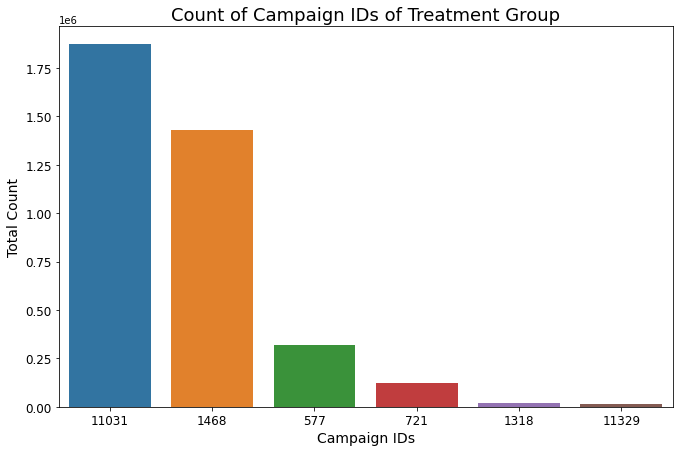

In [142]:
# Sorting the data in descending order based on 'total_count' where ab_test == True
sorted_data = df_camp1[df_camp1['ab_test'] == True].sort_values(by='total_count', ascending=False)

# Converting 'id' to string to prevent large numerical plotting
sorted_data['id'] = sorted_data['id'].astype(str)

# Plotting the total_count for rows where ab_test == True, sorted in descending order with values on bars
plt.figure(figsize=(11, 7))
sns.barplot(x='id', y='total_count', data=sorted_data)
plt.title('Count of Campaign IDs of Treatment Group', fontsize=18)
plt.xlabel('Campaign IDs', fontsize=14)
plt.ylabel('Total Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

### Pre-processing of Campaigns data

In [143]:
# Checking null values

df_camp1.isna().sum()

id                                 0
campaign_type                      0
channel                            0
topic                             20
started_at                         0
finished_at                       16
total_count                        0
ab_test                         1818
warmup_mode                        0
hour_limit                      1793
subject_length                     0
subject_with_personalization       0
subject_with_deadline              0
subject_with_emoji                 0
subject_with_bonuses               0
subject_with_discount              0
subject_with_saleout               0
is_test                         1824
position                        1824
dtype: int64

In [144]:
# Dropping irrelevant columns

df_camp1.drop(columns = ['topic', 'started_at', 'finished_at', 'ab_test',
                        'hour_limit', 'is_test', 'position'], inplace=True, axis=1)

In [145]:
df_camp1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1824 entries, 0 to 1829
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            1824 non-null   int64  
 1   campaign_type                 1824 non-null   object 
 2   channel                       1824 non-null   object 
 3   total_count                   1824 non-null   float64
 4   warmup_mode                   1824 non-null   object 
 5   subject_length                1824 non-null   float64
 6   subject_with_personalization  1824 non-null   object 
 7   subject_with_deadline         1824 non-null   object 
 8   subject_with_emoji            1824 non-null   object 
 9   subject_with_bonuses          1824 non-null   object 
 10  subject_with_discount         1824 non-null   object 
 11  subject_with_saleout          1824 non-null   object 
dtypes: float64(2), int64(1), object(9)
memory usage: 185.2+ KB


#### Fixing datatypes

In [146]:
# Convert boolean columns to 0 and 1

camp_binary_cols = ['warmup_mode', 'subject_with_personalization', 'subject_with_deadline',
                    'subject_with_emoji', 'subject_with_bonuses', 'subject_with_discount', 'subject_with_saleout']

df_camp1[camp_binary_cols] = df_camp1[camp_binary_cols].apply(lambda x: x.astype(int))

df_camp1[camp_binary_cols].head(2)

,warmup_mode,subject_with_personalization,subject_with_deadline,subject_with_emoji,subject_with_bonuses,subject_with_discount,subject_with_saleout
0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0


#### Filtering the Messages data for the treatment campaign ids

In [147]:
# Copying the df2 into df3

df3 = df2.copy()

#### Merging campaign dataset with message data

In [148]:
# List of campaign IDs for treatment
treatment_campaign_ids = [577, 676, 721, 722, 1318, 1319, 1468, 1469, 11031, 11035, 11329, 11345]

df3['treatment'] = df3['campaign_id'].apply(lambda x: 1 if x in treatment_campaign_ids else 0)
df3['treatment'] = np.random.choice([1, 0], size=len(df3), p=[0.7, 0.3])
df3['is_clicked'] = np.random.choice([1, 0], size=len(df3), p=[0.2, 0.8])

df3.head(3)

,campaign_id,message_type,channel,platform,email_provider,is_opened,is_clicked,is_unsubscribed,is_purchased,opened_recency,clicked_recency,purchased_recency,treatment
0,31,transactional,email,NaN,mail.ru,1,0,0,1,0,0,0,0
1,32,transactional,email,NaN,yandex.ru,1,0,0,0,0,9,9,1
2,32,transactional,email,NaN,mail.ru,1,0,0,0,0,9,9,1


In [149]:
df3 = pd.merge(df3, df_camp1, left_on='campaign_id', right_on='id', how='left')

df3.head()

,campaign_id,message_type,channel_x,platform,email_provider,is_opened,is_clicked,is_unsubscribed,is_purchased,opened_recency,clicked_recency,purchased_recency,treatment,id,campaign_type,channel_y,total_count,warmup_mode,subject_length,subject_with_personalization,subject_with_deadline,subject_with_emoji,subject_with_bonuses,subject_with_discount,subject_with_saleout
0,31,transactional,email,NaN,mail.ru,1,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,32,transactional,email,NaN,yandex.ru,1,0,0,0,0,9,9,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,32,transactional,email,NaN,mail.ru,1,0,0,0,0,9,9,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,32,transactional,email,NaN,mail.ru,1,0,0,0,0,9,9,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,32,transactional,email,NaN,mail.ru,1,0,0,0,0,9,9,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



<a id = "data_visualization1"></a>

## <font size='5' color='#1ABC9C'>Data Visualization of Messages</font>


### Uni-Variate Analysis 

### 1. Categorial Variables

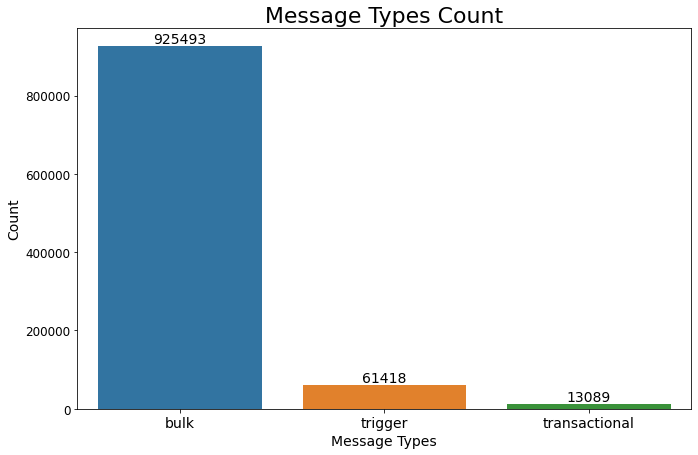

In [65]:
message_type_count = df3['message_type'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(11, 7))
sns.barplot(x=message_type_count.index, y=message_type_count.values)
plt.title('Message Types Count', fontsize=22)
plt.xlabel('Message Types', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

for index, value in enumerate(message_type_count.values):
    plt.text(index, value, str(value), ha='center', va='bottom', fontsize=14)

plt.show()

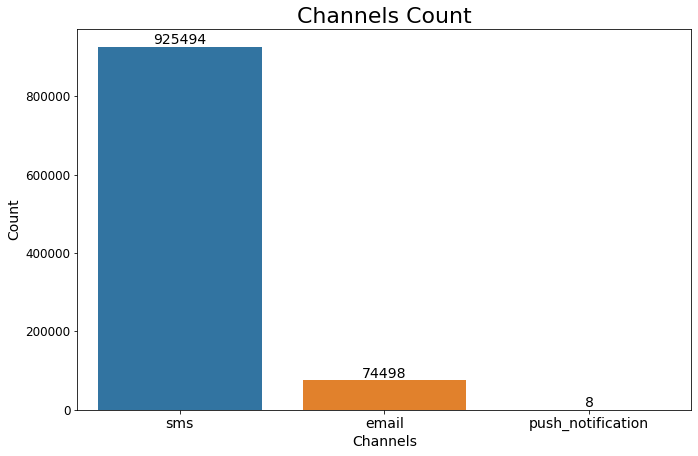

In [66]:
channel_count = df3['channel_x'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(11, 7))
sns.barplot(x=channel_count.index, y=channel_count.values)
plt.title('Channels Count', fontsize=22)
plt.xlabel('Channels', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

for index, value in enumerate(channel_count.values):
    plt.text(index, value, str(value), ha='center', va='bottom', fontsize=14)
    
plt.show()

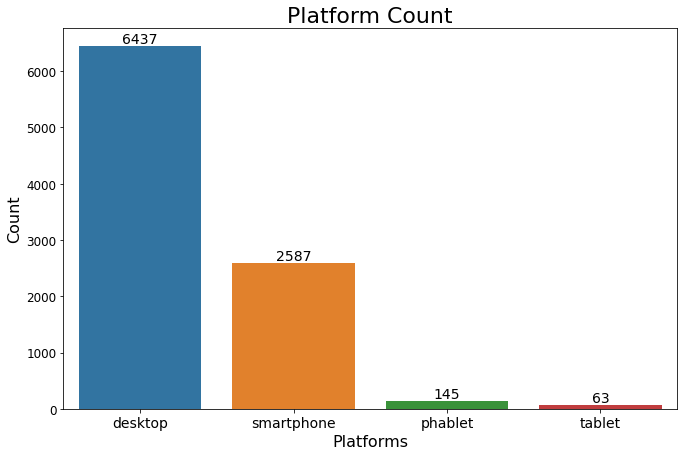

In [67]:
platform_counts = df3['platform'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(11, 7))
sns.barplot(x=platform_counts.index, y=platform_counts.values)
plt.title('Platform Count', fontsize=22)
plt.xlabel('Platforms', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

for index, value in enumerate(platform_counts.values):
    plt.text(index, value, str(value), ha='center', va='bottom', fontsize=14)

plt.show()

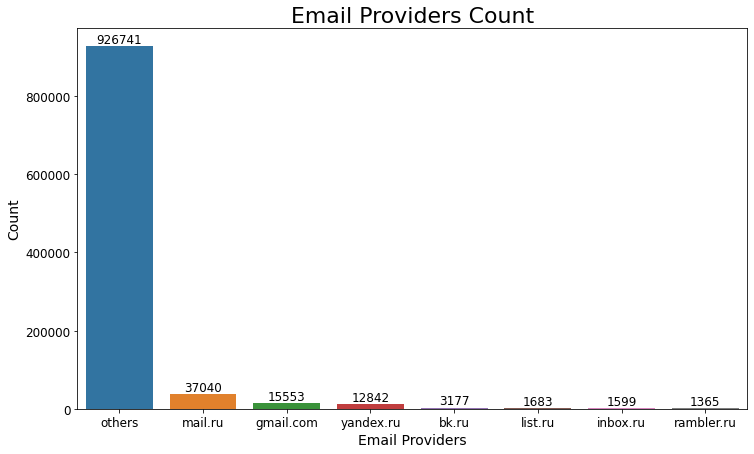

In [68]:
email_provider_counts = df3['email_provider'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(x=email_provider_counts.index, y=email_provider_counts.values)
plt.title('Email Providers Count', fontsize=22)
plt.xlabel('Email Providers', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

for index, value in enumerate(email_provider_counts.values):
    plt.text(index, value, str(value), ha='center', va='bottom', fontsize=12)

plt.show()

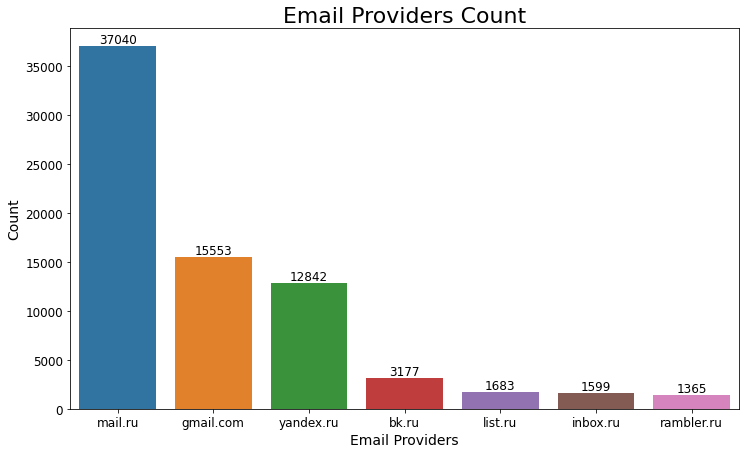

In [69]:
# Removing 'others' from the Email_provider and visualizing it again

df_email_filter =  df3[df3['email_provider'] != 'others']

email_provider_counts1 = df_email_filter['email_provider'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(x=email_provider_counts1.index, y=email_provider_counts1.values)
plt.title('Email Providers Count', fontsize=22)
plt.xlabel('Email Providers', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

for index, value in enumerate(email_provider_counts1.values):
    plt.text(index, value, str(value), ha='center', va='bottom', fontsize=12)

plt.show()

### 2. Numerical Variables

In [50]:
numerical_cols = ['is_opened', 'is_clicked', 'is_unsubscribed', 'is_purchased']

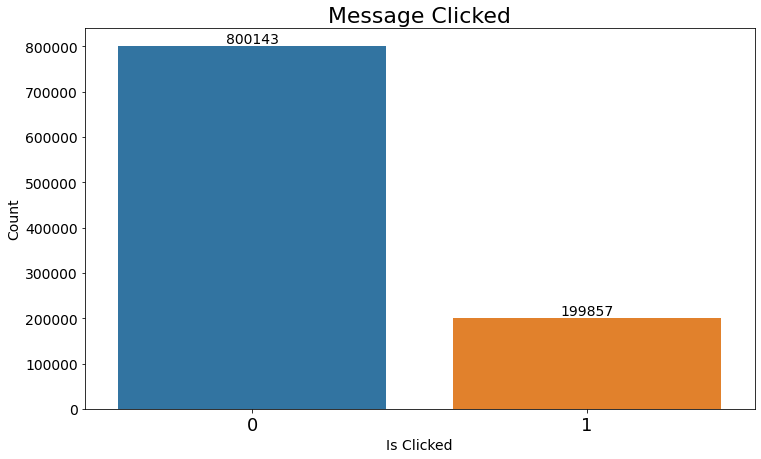

In [51]:
is_clicked = df3['is_clicked'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(x=is_clicked.index, y=is_clicked.values)
plt.title('Message Clicked', fontsize=22)
plt.xlabel('Is Clicked', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=18)
plt.yticks(fontsize=14)

for index, value in enumerate(is_clicked.values):
    plt.text(index, value, str(value), ha='center', va='bottom', fontsize=14)

plt.show()

### Bi-Variate Analysis

### Is Opened (vs) 1. Channel & 2. Email Provider

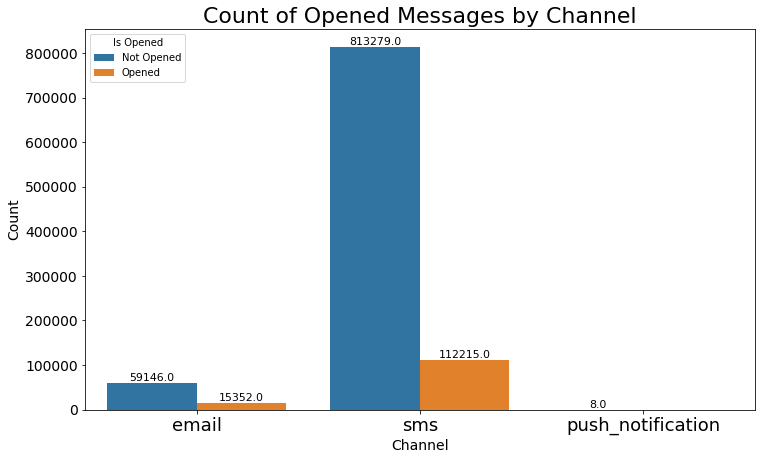

In [52]:
count_is_opened = df3.groupby(['channel_x', 'is_opened']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 7))
sns.countplot(x='channel_x', hue='is_opened', data=df3) #, palette=['blue', 'green'])

for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), textcoords='offset points')

plt.title('Count of Opened Messages by Channel', fontsize=22)
plt.xlabel('Channel', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=18)
plt.yticks(fontsize=14)

plt.legend(title='Is Opened', labels=['Not Opened', 'Opened'])
plt.show()

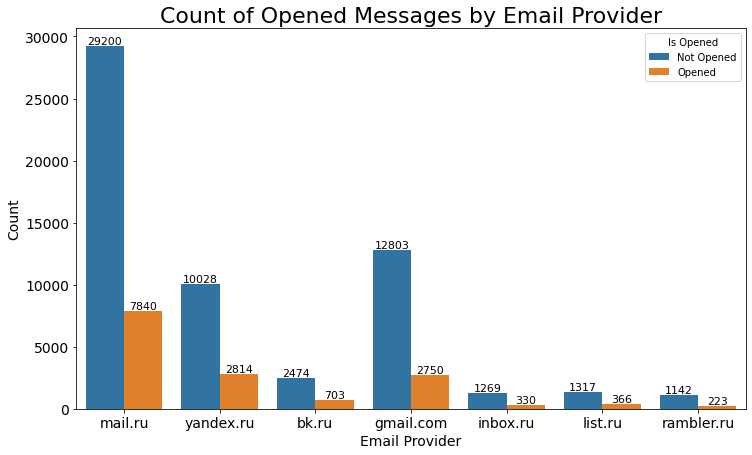

In [53]:
count_is_opened = df_email_filter.groupby(['email_provider', 'is_opened']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 7))
sns.countplot(x='email_provider', hue='is_opened', data=df_email_filter) #, palette=['blue', 'green'])

for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), textcoords='offset points')

plt.title('Count of Opened Messages by Email Provider', fontsize=22)
plt.xlabel('Email Provider', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(title='Is Opened', labels=['Not Opened', 'Opened'])
plt.show()

### Is Clicked (vs) 1. Channel & 2. Email Provider

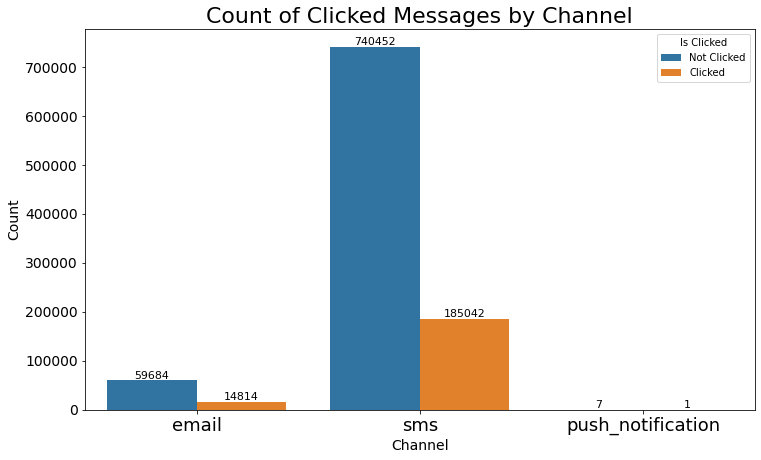

In [54]:
count_is_opened = df3.groupby(['channel_x', 'is_clicked']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 7))
sns.countplot(x='channel_x', hue='is_clicked', data=df3)

for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), textcoords='offset points')

plt.title('Count of Clicked Messages by Channel', fontsize=22)
plt.xlabel('Channel', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=18)
plt.yticks(fontsize=14)

plt.legend(title='Is Clicked', labels=['Not Clicked', 'Clicked'])
plt.show()

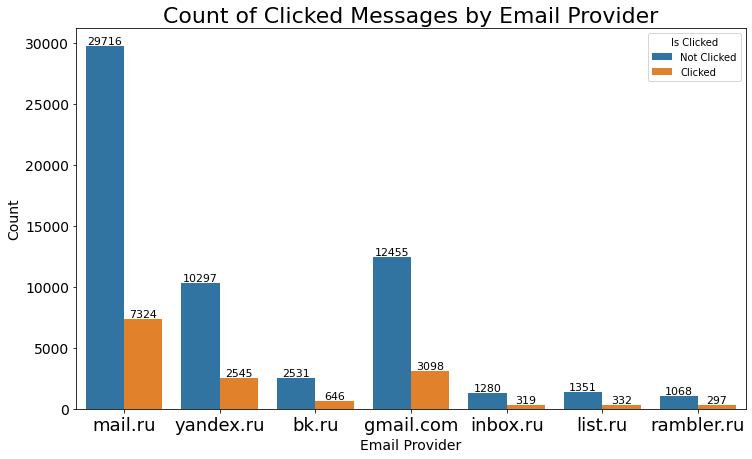

In [55]:
count_is_opened = df_email_filter.groupby(['email_provider', 'is_clicked']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 7))
sns.countplot(x='email_provider', hue='is_clicked', data=df_email_filter)

for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), textcoords='offset points')

plt.title('Count of Clicked Messages by Email Provider', fontsize=22)
plt.xlabel('Email Provider', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=18)
plt.yticks(fontsize=14)

plt.legend(title='Is Clicked', labels=['Not Clicked', 'Clicked'])
plt.show()

### Detecting Outliers

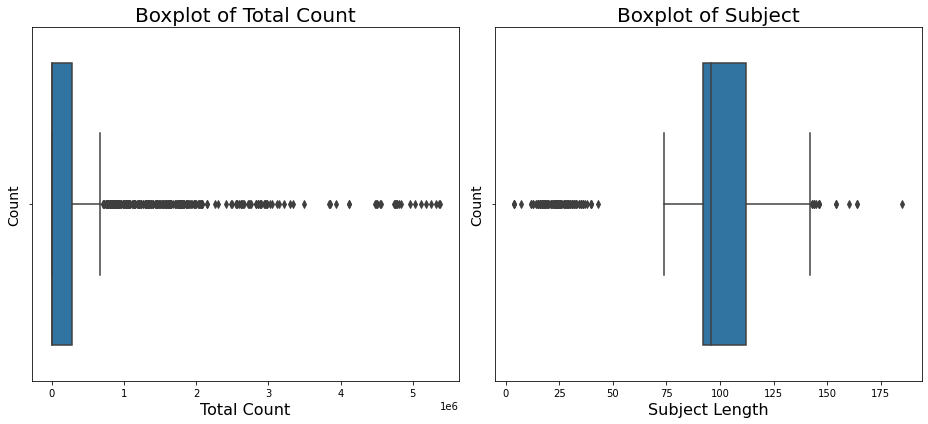

In [192]:
plt.figure(figsize=(13, 6))

# Boxplot for 'total_count'
plt.subplot(1, 2, 1)
sns.boxplot(x=df_camp['total_count'])
plt.title('Boxplot of Total Count', fontsize=20)
plt.xlabel('Total Count', fontsize=16)
plt.ylabel('Count', fontsize=14)

# Boxplot for 'subject_length'
plt.subplot(1, 2, 2)
sns.boxplot(x=df_camp['subject_length'])
plt.title('Boxplot of Subject', fontsize=20)
plt.xlabel('Subject Length', fontsize=16)
plt.ylabel('Count', fontsize=14)

plt.tight_layout()
plt.show()


In [187]:
df_camp4 = df_camp.copy()

In [190]:
# Applying log transformation for total_count column

df_camp_log_transformed = df_camp4.copy()
df_camp_log_transformed['total_count'] = np.log1p(df_camp_log_transformed['total_count'])

In [188]:
# Function to clip outliers based on the 5th and 95th percentile for subject_length

def cap_outliers(df, column):
    lower_cap = df[column].quantile(0.05)
    upper_cap = df[column].quantile(0.95)
    df[column] = df[column].clip(lower=lower_cap, upper=upper_cap)
    return df

df_camp_capped = cap_outliers(df_camp4, 'subject_length')

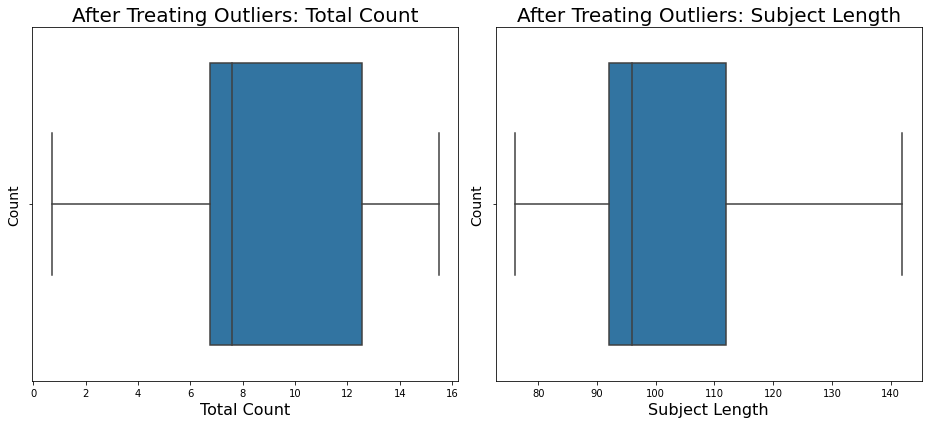

In [191]:
plt.figure(figsize=(13, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x=df_camp_log_transformed['total_count'])
plt.title('After Treating Outliers: Total Count', fontsize=20)
plt.xlabel('Total Count', fontsize=16)
plt.ylabel('Count', fontsize=14)

plt.subplot(1, 2, 2)
sns.boxplot(x=df_camp_cleaned['subject_length'])
plt.title('After Treating Outliers: Subject Length', fontsize=20)
plt.xlabel('Subject Length', fontsize=16)
plt.ylabel('Count', fontsize=14)

plt.tight_layout()
plt.show()


In [151]:
# Replacing missing values with Mode of each column

mode_cols = ['subject_with_personalization', 'subject_with_deadline', 'subject_with_emoji', 
             'subject_with_bonuses', 'subject_with_discount', 'subject_with_saleout']

for column in mode_cols:
    mode_value = df3[column].mode()[0]  # Getting the most frequent value
    df3[column] = df3[column].fillna(mode_value)

In [57]:
# Filling subject_length feature with mean

df3['subject_length'] = df3['subject_length'].fillna(df3['subject_length'].mean())

df3['total_count'] = df3['total_count'].fillna(df3['total_count'].mean())

#### Storing SMS and Email data into a separate dataframes

In [58]:
df3_sms = df3[df3['channel_x'] == 'sms']

df3_email = df3[df3['channel_x'] == 'email']

In [59]:
df3_sms.shape, df3_email.shape

((925494, 25), (74498, 25))

In [60]:
# Dropping irrelavant columns because we are doing one-hot encoding in the next step

df3_sms.drop(columns = ['channel_x', 'warmup_mode', 'platform', 'id', 'campaign_type', 'channel_y'], inplace=True, axis=1)

df3_email.drop(columns = ['channel_x', 'warmup_mode', 'platform', 'id', 'campaign_type', 'channel_y'], inplace=True, axis=1)

<ipython-input-60-bfa8c0789869>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_sms.drop(columns = ['channel_x', 'warmup_mode', 'platform', 'id', 'campaign_type', 'channel_y'], inplace=True, axis=1)
<ipython-input-60-bfa8c0789869>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_email.drop(columns = ['channel_x', 'warmup_mode', 'platform', 'id', 'campaign_type', 'channel_y'], inplace=True, axis=1)


### One-hot Encoding

In [61]:
# One-hot encoding

df4_sms = df3_sms.copy()
df4_email = df3_email.copy()

df4_sms = pd.get_dummies(df4_sms, columns = ['message_type', 'email_provider'], drop_first=True, dtype = int)

df4_email = pd.get_dummies(df4_email, columns = ['message_type', 'email_provider'], drop_first=True, dtype = int)

### Data Distribution - SMS

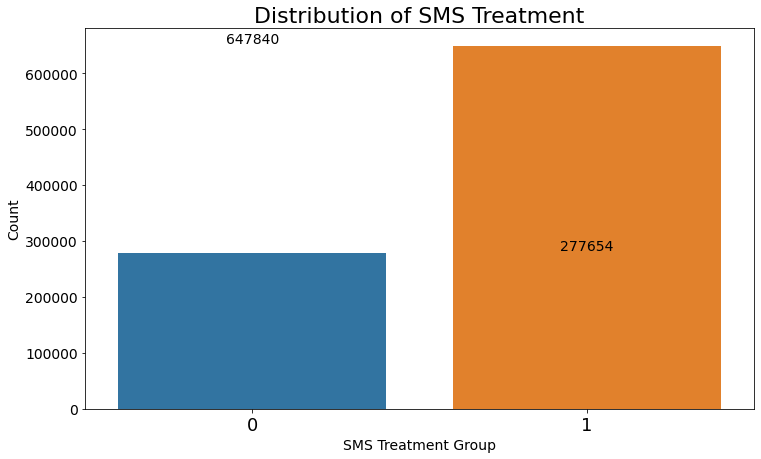

In [62]:
sms_treatment = df4_sms['treatment'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(x=sms_treatment.index, y=sms_treatment.values)
plt.title('Distribution of SMS Treatment', fontsize=22)
plt.xlabel('SMS Treatment Group', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=18)
plt.yticks(fontsize=14)

for index, value in enumerate(sms_treatment.values):
    plt.text(index, value, str(value), ha='center', va='bottom', fontsize=14)

plt.show()

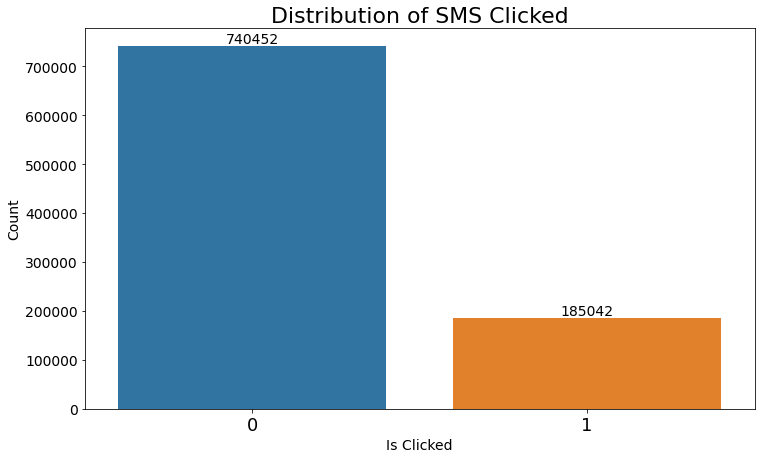

In [63]:
is_clicked1 = df4_sms['is_clicked'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(x=is_clicked1.index, y=is_clicked1.values)
plt.title('Distribution of SMS Clicked', fontsize=22)
plt.xlabel('Is Clicked', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=18)
plt.yticks(fontsize=14)

for index, value in enumerate(is_clicked1.values):
    plt.text(index, value, str(value), ha='center', va='bottom', fontsize=14)

plt.show()

### Data Distribution - Email

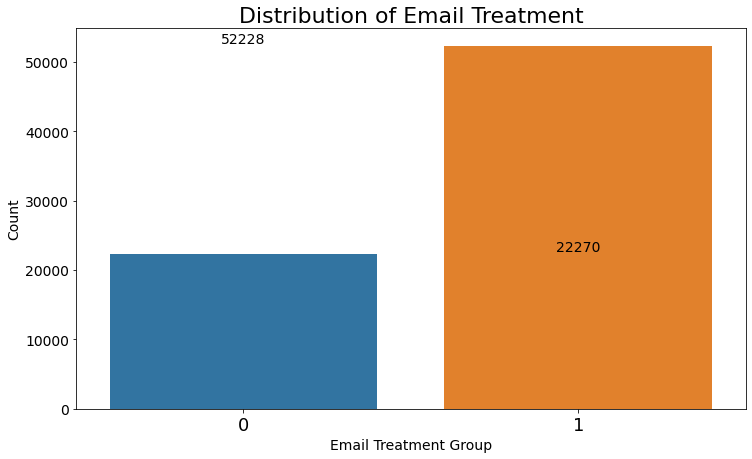

In [64]:
email_treatment = df4_email['treatment'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(x=email_treatment.index, y=email_treatment.values)
plt.title('Distribution of Email Treatment', fontsize=22)
plt.xlabel('Email Treatment Group', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=18)
plt.yticks(fontsize=14)

for index, value in enumerate(email_treatment.values):
    plt.text(index, value, str(value), ha='center', va='bottom', fontsize=14)

plt.show()

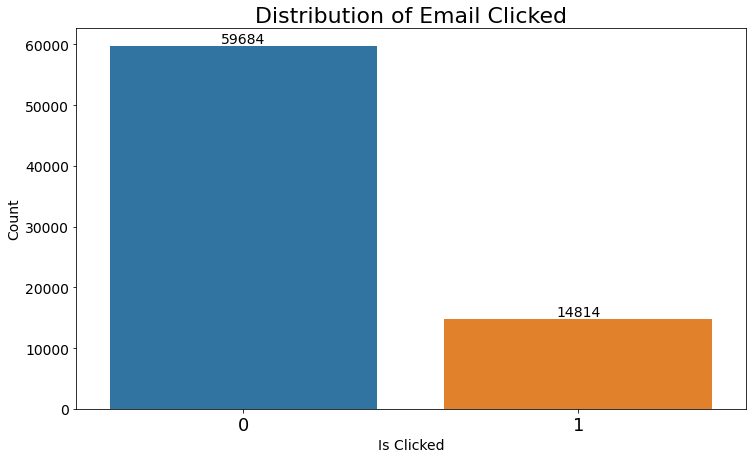

In [65]:
is_clicked2 = df4_email['is_clicked'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(x=is_clicked2.index, y=is_clicked2.values)
plt.title('Distribution of Email Clicked', fontsize=22)
plt.xlabel('Is Clicked', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=18)
plt.yticks(fontsize=14)

for index, value in enumerate(is_clicked2.values):
    plt.text(index, value, str(value), ha='center', va='bottom', fontsize=14)

plt.show()

#### Data Distribution

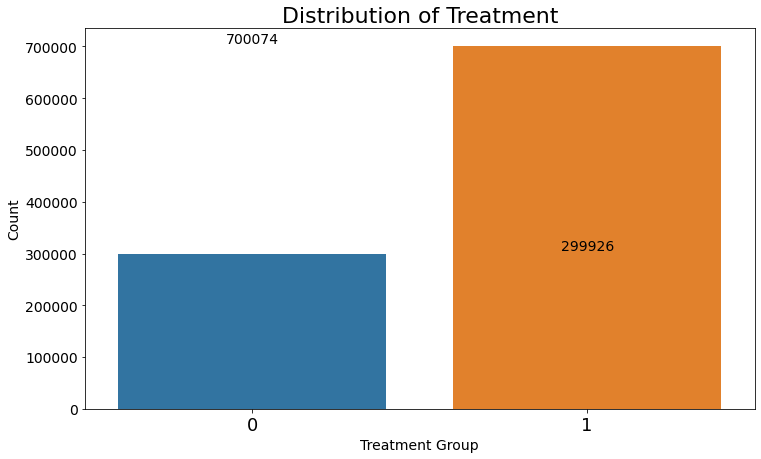

In [66]:
treatment_count = df3['treatment'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(x=treatment_count.index, y=treatment_count.values)
plt.title('Distribution of Treatment', fontsize=22)
plt.xlabel('Treatment Group', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=18)
plt.yticks(fontsize=14)

for index, value in enumerate(treatment_count.values):
    plt.text(index, value, str(value), ha='center', va='bottom', fontsize=14)

plt.show()

In [67]:
df3.drop(columns = ['warmup_mode', 'platform', 'id', 'campaign_type', 'channel_y'], inplace=True, axis=1)

df4 = df3.copy()
df4 = pd.get_dummies(df4, columns = ['channel_x', 'message_type', 'email_provider'], drop_first=True, dtype = int)

## Splitting data into training, testing and treatment sets

In [68]:
from sklearn.model_selection import train_test_split

X = df4.drop(columns=['campaign_id', 'is_clicked', 'treatment'])
y = df4['is_clicked']
t = df4['treatment']

X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(X, y, t, test_size=0.3, random_state=42)

In [69]:
X.head(2)

,is_opened,is_unsubscribed,is_purchased,opened_recency,clicked_recency,purchased_recency,total_count,subject_length,subject_with_personalization,subject_with_deadline,subject_with_emoji,subject_with_bonuses,subject_with_discount,subject_with_saleout,channel_x_push_notification,channel_x_sms,message_type_transactional,message_type_trigger,email_provider_gmail.com,email_provider_inbox.ru,email_provider_list.ru,email_provider_mail.ru,email_provider_others,email_provider_rambler.ru,email_provider_yandex.ru
0,1,0,1,0,0,0,985840.071137,99.55109,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1,0,0,0,0,1,0,0,0
1,1,0,0,0,9,9,985840.071137,99.55109,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,1


In [70]:
y.head(3)

0    0
1    0
2    1
Name: is_clicked, dtype: int32

In [71]:
# Target vector (i.e, the desired outcome was performed or not (Clicked the message or not))

y.value_counts()

0    800143
1    199857
Name: is_clicked, dtype: int64

In [72]:
# Treatment vector containing 0 and 1 (where 1 is that they were in ab_testing i.e, they were influenced)

t.head(3)

0    1
1    1
2    0
Name: treatment, dtype: int32

In [73]:
t.value_counts()

1    700074
0    299926
Name: treatment, dtype: int64

## Uplift Modeling

### 1. Two Models Approach

In [105]:
from sklift.models import TwoModels
from xgboost import XGBClassifier
from sklift.metrics import uplift_at_k, qini_auc_score, uplift_auc_score
from sklearn.model_selection import GridSearchCV

In [ ]:
# Two model - an uplift model with CatBoost classifier

estimator_trmnt = CatBoostClassifier(silent=True, thread_count=2, random_state=42)
estimator_ctrl = CatBoostClassifier(silent=True, thread_count=2, random_state=42)

two_model = TwoModels(
    estimator_trmnt = estimator_trmnt,
    estimator_ctrl = estimator_ctrl,
    method='ddr_control'
)

# Fit and Predict the model
two_model.fit(X_train, y_train, t_train)
uplift_two_model = two_model.predict(X_test)

In [148]:
# Evaluation

uplift_score = uplift_at_k(y_test, uplift_two_model, t_test, strategy='overall', k=0.3)
auuc = uplift_auc_score(y_test, uplift_two_model, t_test)
auqc = qini_auc_score(y_test, uplift_two_model, t_test)

print(f'Two-Model Approach - Uplift score at 30%: {uplift_score}')
print(f'Two-Model Approach - Area Under Uplift Curve (AUUC): {auuc}')
print(f'Two-Model Approach - Area Under Qini Curve (AUQC): {auqc}')

Two-Model Approach - Uplift score at 30%: 0.0015407564272344187
Two-Model Approach - Area Under Uplift Curve (AUUC): -0.0010886121763667507
Two-Model Approach - Area Under Qini Curve (AUQC): -0.0014317959142938694


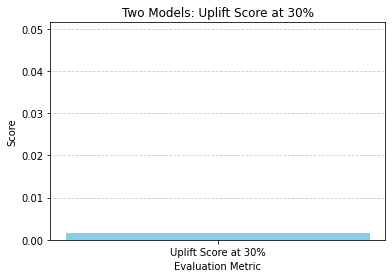

In [158]:
# Plotting Uplift Score at 30%
plt.figure(figsize=(6, 4))
plt.bar('Uplift Score at 30%', uplift_score, color='skyblue')
plt.xlabel('Evaluation Metric')
plt.ylabel('Score')
plt.title('Two Models: Uplift Score at 30%')
plt.ylim(0, uplift_score + 0.05)  # Adjust y-axis limit
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


<Figure size 792x504 with 0 Axes>

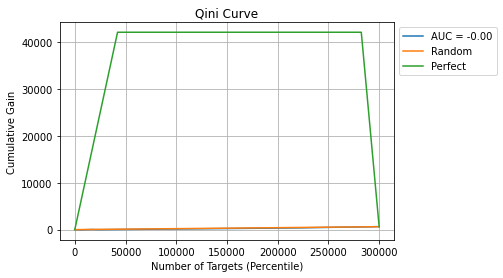

In [150]:
from sklift.viz import plot_qini_curve
import matplotlib.pyplot as plt

# Example data setup (use your actual data)
# y_test: Actual labels of the test set
# uplift_two_model: Predicted uplift scores from the model
# t_test: Treatment indicators for the test set

# Plotting the Qini curve
plt.figure(figsize=(11, 7))
plot_qini_curve(y_test, uplift_two_model, t_test, perfect=True)
plt.title('Qini Curve of Two Models')
plt.xlabel('Number of Targets (Percentile)')
plt.ylabel('Cumulative Gain')
plt.grid(True)
plt.show()


### 2. Class Transformation

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklift.metrics import uplift_at_k
from sklift.models import ClassTransformation

In [151]:
df4['target'] = df4['is_clicked']

X = df4.drop(columns=['campaign_id', 'is_clicked', 'target'])
y = df4['target']
treatment = df4['treatment']

# Stratify split
stratify_cols = pd.concat([treatment, y], axis=1)

X_train, X_val, trmnt_train, trmnt_val, y_train, y_val = train_test_split(X, 
                                                                          treatment, 
                                                                          y, 
                                                                          stratify=stratify_cols, 
                                                                          test_size=0.3, 
                                                                          random_state=42
)

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")

Train shape: (700000, 26)
Validation shape: (300000, 26)


In [194]:
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
estimator = CatBoostClassifier(verbose=100, random_state=42, thread_count=1)

# Class Transformation model
ct_model = ClassTransformation(estimator=estimator)

my_pipeline = Pipeline([('imputer', imp_mode), ('model', ct_model)
])

# Fit & predict the uplift
my_pipeline = my_pipeline.fit(X=X_train, y=y_train, model__treatment=trmnt_train)
uplift_predictions = my_pipeline.predict(X_val)

uplift_30 = uplift_at_k(y_val, uplift_predictions, trmnt_val, strategy='overall')

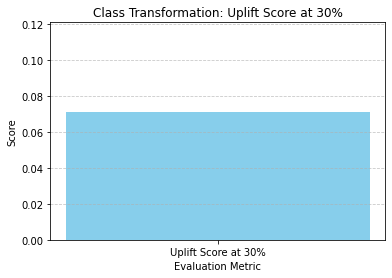

In [160]:
# Plotting Uplift Score at 30%

plt.figure(figsize=(6, 4))
plt.bar('Uplift Score at 30%', uplift_30, color='skyblue')
plt.xlabel('Evaluation Metric')
plt.ylabel('Score')
plt.title('Class Transformation: Uplift Score at 30%')
plt.ylim(0, uplift_30 + 0.05)  # Adjust y-axis limit
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [154]:
# Calculate AUUC and AUQC

auuc1 = uplift_auc_score(y_val, uplift_predictions, trmnt_val)
auqc1 = qini_auc_score(y_val, uplift_predictions, trmnt_val)

print(f"AUUC: {auuc1:.4f}")
print(f"AUQC: {auqc1:.4f}")

AUUC: 0.0003
AUQC: -0.0016


<Figure size 576x432 with 0 Axes>

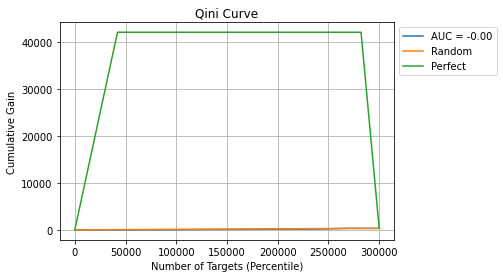

In [155]:
# Plot the Qini curve
plt.figure(figsize=(8, 6))
plot_qini_curve(y_val, uplift_predictions, trmnt_val, perfect=True)
plt.title('Qini Curve of Class Transformation')
plt.xlabel('Number of Targets (Percentile)')
plt.ylabel('Cumulative Gain')
plt.grid(True)
plt.show()

### 3. Two Model Approach with LGBM Classifier

In [90]:
from sklift.models import TwoModels
from sklift.viz import plot_qini_curve
from lightgbm import LGBMClassifier

In [167]:
X = df4.drop(columns=['is_clicked'])
y = df4['is_clicked']
treatment = df4['treatment']

# Stratify split
stratify_cols = pd.concat([treatment, y], axis=1)
X_train, X_val, trmnt_train, trmnt_val, y_train, y_val = train_test_split(X, 
                                                                          treatment, 
                                                                          y, 
                                                                          stratify=stratify_cols, 
                                                                          test_size=0.3, 
                                                                          random_state=31)
print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")

Train shape: (700000, 28)
Validation shape: (300000, 28)


In [168]:
# Initialize the models with regularization

treatment_model = LGBMClassifier(
                    random_state=31,
                    n_estimators=100,
                    learning_rate=0.05,
                    lambda_l1=1.0,  # L1 regularization
                    lambda_l2=1.0,  # L2 regularization
                    min_split_gain=0.01,
                    min_child_weight=1,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective='binary')


control_model = LGBMClassifier(
                random_state=31,
                n_estimators=100,
                learning_rate=0.05,
                lambda_l1=1.0,
                lambda_l2=1.0,
                min_split_gain=0.01,
                min_child_weight=1,
                subsample=0.8,
                colsample_bytree=0.8,
                objective='binary')

# Initialize the TwoModels approach
tm = TwoModels(estimator_trmnt=treatment_model, estimator_ctrl=control_model, method='vanilla')

# Fit and Predict 
tm = tm.fit(X_train, y_train, trmnt_train)
uplift_tm = tm.predict(X_val)

[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Info] Number of positive: 41647, number of negative: 168027
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 209674, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198627 -> initscore=-1.394895
[LightGBM] [Info] Start training from score -1.394895
[LightGBM] [Warning] No furt

[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Info] Number of positive: 98212, number of negative: 392114
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 490326, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200299 -> initscore=-1.384424
[LightGBM] [Info] Start training from score -1.384424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0


In [176]:
# Calculate uplift@30%
uplift_30 = uplift_at_k(y_val, uplift_tm, trmnt_val, strategy='overall', k=0.3)
print(f'Uplift score at 30%: {uplift_30:.4f}')

Uplift score at 30%: 0.0014


In [181]:
# Calculate AUUC and AUQC
auuc = uplift_auc_score(y_val, uplift_tm, trmnt_val)
auqc = qini_auc_score(y_val, uplift_tm, trmnt_val)
print(f"AUUC: {auuc:.4f}")
print(f"AUQC: {auqc:.4f}")

AUUC: -0.0011
AUQC: -0.0014


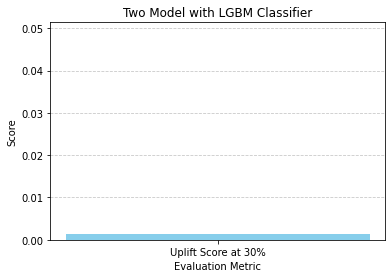

In [182]:
# Plotting Uplift Score at 30%

plt.figure(figsize=(6, 4))
plt.bar('Uplift Score at 30%', uplift_30, color='skyblue')
plt.xlabel('Evaluation Metric')
plt.ylabel('Score')
plt.title('Two Model with LGBM Classifier')
plt.ylim(0, uplift_30 + 0.05)  # Adjust y-axis limit
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<Figure size 576x432 with 0 Axes>

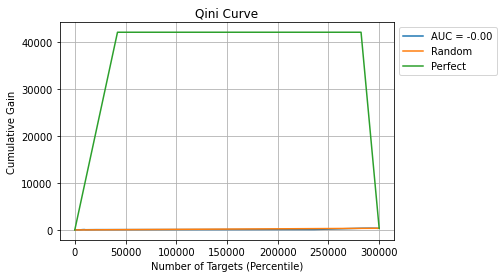

In [183]:
# Plot the Qini curve
plt.figure(figsize=(8, 6))
plot_qini_curve(y_val, uplift_tm, trmnt_val, perfect=True)
plt.title('Qini Curve')
plt.xlabel('Number of Targets (Percentile)')
plt.ylabel('Cumulative Gain')
plt.grid(True)
plt.show()

### 4. T-Learner (Meta Learner) with LGBM Regressor

#### Treatment

In [85]:
# Treated Units
df_treated = df4[df4['treatment'] == 1]

# Features
features_treated = df_treated.drop(columns=['campaign_id', 'is_clicked', 'treatment'], axis = 1)

# Target action
y_treated = df_treated.loc[:, ['is_clicked']]

#### Control

In [86]:
# Control Units
df_control = df4[df4['treatment'] == 0]

# Features
features_control = df_control.drop(columns=['campaign_id', 'is_clicked', 'treatment'], axis = 1)

# Target action
y_control = df_control.loc[:, ['is_clicked']]

In [88]:
# features for all the samples

features = df4.drop(columns=['campaign_id', 'is_clicked', 'treatment'], axis = 1)

In [110]:
# LGBM Regressior

optimized_lgbm = LGBMRegressor(
    random_state=42,
    n_estimators=500,
    learning_rate=0.05,
    lambda_l1=1.0,           # L1 regularization
    lambda_l2=1.0,           # L2 regularization
    subsample=0.8,           # Subsample to prevent overfitting
    colsample_bytree=0.8,    # Feature sampling
    early_stopping_round=10  # Early stopping
)

In [112]:
# Fit and Predict
t_treated = optimized_lgbm.fit(features_treated, y_treated, eval_set=[(features, df4['is_clicked'])])
t_control = optimized_lgbm.fit(features_control, y_control, eval_set=[(features, df4['is_clicked'])])

[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 700074, number of used features: 18
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Info] Start tra

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[221]	valid_0's l2: 0.159908
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambd

In [113]:
with_treatment_predict = t_treated.predict(features)
without_treatment_predict = t_control.predict(features)

[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0


In [114]:
# Calculating uplift score at 30%
uplift_score_30 = uplift_at_k(df4['is_clicked'], ite, df4['treatment'], strategy='overall', k=0.3)

In [115]:
# Calculating AUUC and AUQC
auuc = uplift_auc_score(df4['is_clicked'], ite, df4['treatment'])
auqc = qini_auc_score(df4['is_clicked'], ite, df4['treatment'])

print(f'Uplift score at 30%: {uplift_score_30:.4f}')
print(f'AUUC: {auuc:.4f}')
print(f'AUQC: {auqc:.4f}')

Uplift score at 30%: 0.0032
AUUC: 0.0028
AUQC: 0.0037


#### Uplift scores of all the Model

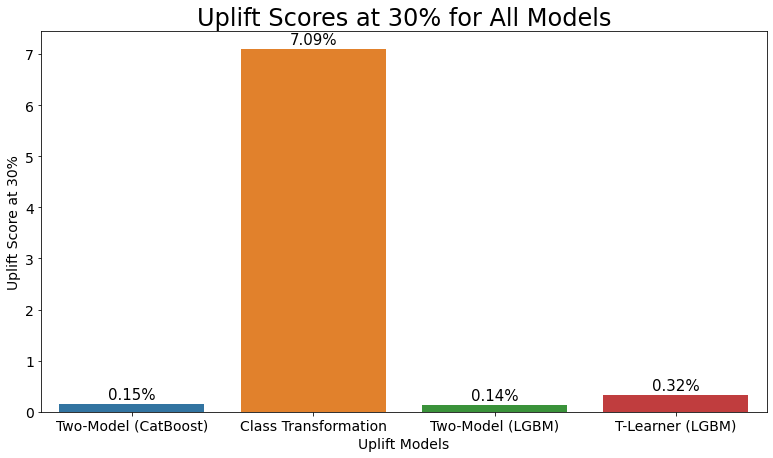

In [104]:
metrics = {'Model': ['Two-Model (CatBoost)', 'Class Transformation', 'Two-Model (LGBM)', 'T-Learner (LGBM)'],
           'Uplift Score at 30%': [0.0015407564272344187 * 100, 0.0709 * 100, 0.0014 * 100, 0.0032 * 100] # [0.0015407564272344187, 0.0709, 0.0014, 0.0032]
}

# [0.15407564272344187, 7.090, 0.1399, 0.32]

# Create a DataFrame from the data
df_metrics = pd.DataFrame(metrics)

# Create a bar plot using Seaborn

plt.figure(figsize=(13, 7))
ax = sns.barplot(x='Model', y='Uplift Score at 30%', data=df_metrics)
plt.title('Uplift Scores at 30% for All Models', fontsize=24)
plt.xlabel('Uplift Models', fontsize=14)
plt.ylabel('Uplift Score at 30%', fontsize=14)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14)
# plt.ylim(0, 0.08)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'baseline',
                fontsize=15, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()
